### 1. Imports and Global Configuration

This cell loads all required Python libraries and sets global configuration
(such as random seeds, plotting style, and model hyperparameters). These
imports are used throughout the notebook for data handling, model training,
and visualization.


In [ ]:
# 1. Imports and global configuration for LGTA & AAC experiments
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


PyTorch version: 2.9.0+cu126
CUDA available: True
Current device: Tesla T4


### 2. Sampling Layer (Reparameterization Trick)

This custom Keras layer implements the reparameterization trick used in VAEs.
Given the mean and log-variance of the latent distribution, it samples a latent
vector `z` in a differentiable way:

$$
z = \mu + \exp\left(\frac{1}{2}\log(\sigma^{2})\right) \odot \epsilon,\quad \epsilon \sim \mathcal{N}(0, I)
$$

This allows gradients to flow through the stochastic sampling step.



In [ ]:
# 2. Custom Sampling layer for the CVAE (reparameterization trick)
import pickle
with open("/content/tourism_groups_M__None_None.pickle", "rb") as f:
    obj = pickle.load(f)

train = obj["train"]       # shape (T, N)
print("Train shape:", train.shape)


### 3. Tourism Dataset Loading and Preprocessing

This cell loads the Tourism dataset from the original `.pickle` file.
The original layout is `(T, N)` (time, number of series). We:

1. Transpose to `(N, T)` so each row is one complete time series.
2. Normalize each series individually (e.g., z-score or min–max).
3. Add a channel dimension to obtain `(N, T, 1)`, which is the expected
   input shape for the CVAE.

We also print shapes and a sample series for sanity checking.



In [ ]:
# 3. Load and preprocess Tourism dataset: (T, N) -> (N, T, 1)
print(type(obj["train"]))
print(obj["train"].keys())

<class 'dict'>
dict_keys(['x_values', 'groups_idx', 'groups_n', 'groups_names', 'n', 's', 'n_series_idx', 'n_series', 'g_number', 'data', 'full_data', 'n_series_idx_full'])


### 4. CVAE Architecture for Tourism Dataset

Here we define the encoder and decoder networks for the Tourism dataset:

- **Encoder:** stacked GRUs produce a sequence embedding; two Dense layers
  output the latent mean and log-variance; the Sampling layer produces `z`.
- **Decoder:** a Dense layer expands `z`, RepeatVector copies it across
  timesteps, and GRU layers followed by a TimeDistributed Dense layer
  reconstruct the time series.

This CVAE will learn a smooth latent space for Tourism series.



In [ ]:
# 4. Define encoder and decoder (CVAE) for Tourism dataset
train_matrix = obj["train"]["data"]   # this is shape (T, N)

print("train_matrix type:", type(train_matrix))
print("train_matrix shape:", train_matrix.shape)

train_matrix type: <class 'numpy.ndarray'>
train_matrix shape: (204, 304)


### 5. Training the Tourism CVAE

The encoder and decoder are now combined into a single CVAE model.
We compile it with mean squared error (MSE) loss and train on the Tourism
dataset. The objective is to reconstruct each input series from its latent
representation, ensuring that the latent space captures meaningful temporal
patterns (trend, seasonality, variability).


In [ ]:
# 5. Build and train the Tourism CVAE
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Convert (T, N) -> (N, T)
X = train_matrix.T    # shape (304, 204)

# Step 2: normalize EACH series independently
scaler = StandardScaler()

# We will normalize series by series
X_norm = np.zeros_like(X)
for i in range(X.shape[0]):
    X_norm[i] = scaler.fit_transform(X[i].reshape(-1, 1)).flatten()

# Step 3: reshape to (N, T, 1)
train_series_reshaped = X_norm[..., np.newaxis]

print("Final shape (N, T, 1):", train_series_reshaped.shape)
print("First series sample:", train_series_reshaped[0, :10, 0])



Final shape (N, T, 1): (304, 204, 1)
First series sample: [0 0 0 2 1 0 1 1 0 0]


### 6. L-GTA Style Latent-Space Augmentations (Tourism)

To mimic the L-GTA framework, we apply several parametric transformations
directly in the latent space of the Tourism CVAE:

- **Scaled**: multiply the latent vector by a constant.
- **Shifted**: add a constant offset.
- **Noisy**: add Gaussian noise.
- **Rotated**: apply a small orthonormal rotation matrix.
- **Combined**: sequentially apply scale + shift + noise + rotation.

We decode each transformed latent vector back to the time domain and plot
the original vs augmented series.




In [ ]:
# 6. Apply L-GTA-style latent augmentations to a Tourism series and plot
import numpy as np
from sklearn.preprocessing import StandardScaler

# Convert (T, N) → (N, T)
X = train_matrix.T.astype("float32")   # <— IMPORTANT

X_norm = np.zeros_like(X)

# Normalize per series
for i in range(X.shape[0]):
    series = X[i].reshape(-1, 1)
    scaler = StandardScaler()
    X_norm[i] = scaler.fit_transform(series).flatten()

# Add channel dim: (N, T, 1)
train_series_reshaped = X_norm[..., np.newaxis]

print("Final shape:", train_series_reshaped.shape)
print("First series sample:", train_series_reshaped[0, :10, 0])
print("dtype:", train_series_reshaped.dtype)


Final shape: (304, 204, 1)
First series sample: [-0.8803793 -0.4921306  0.6467322  2.54268    1.7273577 -0.615076
  1.3455799  1.9020697  0.7373236  0.0061219]
dtype: float32


### 7. Feature Extraction for Adaptive Policy Selection

This cell defines functions to extract summary statistics from a time series,
including:

- Trend (last value − first value)
- Linear slope (via `np.polyfit`)
- Standard deviation
- Skewness and kurtosis
- Optional seasonality strength or autocorrelation

These features are later used by the Adaptive Augmentation Controller (AAC)
to decide which augmentation types are most suitable for a given series.



In [ ]:
# 7. Feature extraction utilities for AAC (trend, slope, std, skew, kurtosis, etc.)
z_numeric, z_mean_numeric, z_log_var_numeric = encoder.predict(train_series_reshaped)

print("Latent Z shape:", z_numeric.shape)
print("Example vector:", z_numeric[0])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Latent Z shape: (304, 8)
Example vector: [-1.1524925   3.0554385   1.5945661  -0.93012154  0.46736407 -0.45962396
 -1.5863053   0.81052816]


### 8. Latent Rotation and Policy Application Helpers

Here we implement two core helpers:

- **`rotation_matrix(angle, dim)`**: builds an orthonormal rotation matrix
  for the latent space (keeps overall magnitude but changes orientation).
- **`apply_policy(z, policy)`**: takes a latent vector `z` and a policy
  dictionary (e.g., `{"scale": 1.1, "shift": 0.2, "noise": 0.05}`) and
  applies the corresponding transformations in sequence.


This is the core mechanism that both L-GTA-style augmentations and AAC use.


In [ ]:
# 8. Helpers: rotation matrix for latent space and function to apply an augmentation policy
import numpy as np

def scale_latent(z, factor=1.2):
    return z * factor

def shift_latent(z, amount=0.1):
    return z + amount

def noise_latent(z, sigma=0.05):
    return z + np.random.normal(0, sigma, z.shape)

def rotate_latent(z, angle_deg=15):
    angle = np.radians(angle_deg)
    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle),  np.cos(angle)]
    ])
    z_rot = z.copy()
    z_rot[:, :2] = z[:, :2] @ R.T
    return z_rot

def combined(z):
    return noise_latent(shift_latent(scale_latent(z, 1.15), 0.05), sigma=0.03)

### 9. Adaptive Augmentation Controller (AAC)

The `AdaptiveAugmentationController` encapsulates the logic for
**data-driven augmentation**:

- Encodes a series into latent space using the CVAE encoder.
- Extracts statistical features from the series.
- Selects an augmentation policy using simple rules (e.g., high variance
  → scaling; strong trend → shifting; heavy tails → noise; clear seasonality
  → rotation; multiple signals → combined).
- Applies the policy in latent space and decodes back to the time domain.

It also provides a `augment_dataset` method to generate augmented samples
for all series in a dataset.


In [ ]:
# 9. Define the AdaptiveAugmentationController (AAC) class Add docstrings inside methods too, e.g.:
#python
#def choose_policy(self, features):
#    """Map extracted series features to an augmentation policy."""


idx = 10    # you can change this to test any series
z0 = z_numeric[idx:idx+1]     # shape (1,8)

z_scaled  = scale_latent(z0, 1.3)
z_shifted = shift_latent(z0, 0.2)
z_noisy   = noise_latent(z0, sigma=0.1)
z_rot     = rotate_latent(z0, 20)
z_combo   = combined(z0)

# Decode
x_orig    = train_series_reshaped[idx,:,0]
x_scaled  = decoder.predict(z_scaled)[0,:,0]
x_shifted = decoder.predict(z_shifted)[0,:,0]
x_noisy   = decoder.predict(z_noisy)[0,:,0]
x_rot     = decoder.predict(z_rot)[0,:,0]
x_combo   = decoder.predict(z_combo)[0,:,0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


### 10. Visualization — L-GTA Style Augmented Time Series
Plots original vs scaled, shifted, noisy, rotated, and combined latent-space
augmentations.


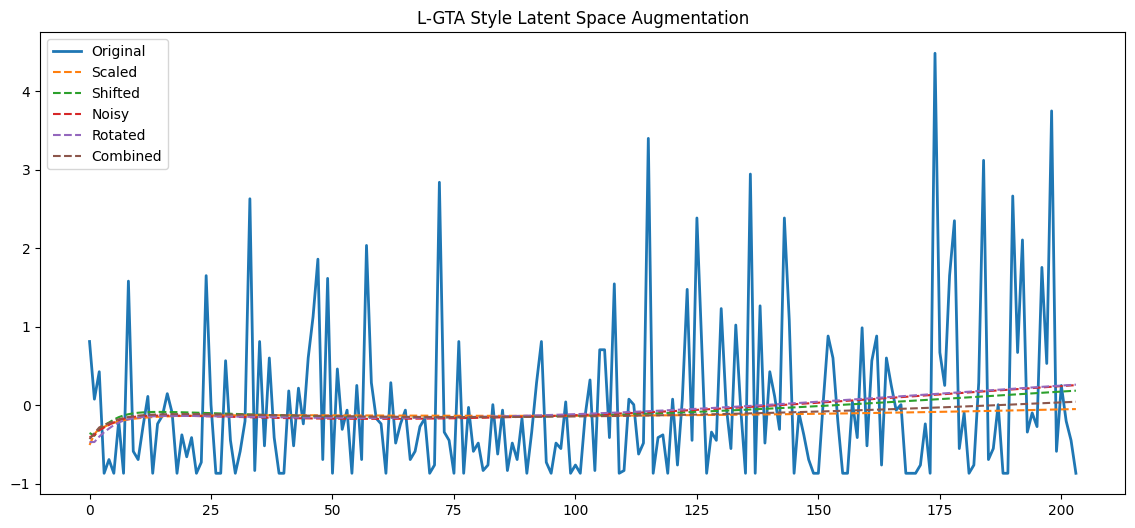

In [ ]:
# 10. Plot original vs augmented (L-GTA style) time-series
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(x_orig, label="Original", linewidth=2)
plt.plot(x_scaled, '--', label="Scaled")
plt.plot(x_shifted, '--', label="Shifted")
plt.plot(x_noisy, '--', label="Noisy")
plt.plot(x_rot, '--', label="Rotated")
plt.plot(x_combo, '--', label="Combined")

plt.title("L-GTA Style Latent Space Augmentation")
plt.legend()
plt.show()

### 11. Build Final Decoder Network
This revised decoder uses:
- Dense layers  
- Reshape  
- Bidirectional GRUs  
- TimeDistributed Dense  
to reconstruct time-series from latent vectors.



In [ ]:
# 11. Define final decoder architecture for VAE

from keras import layers, Model, Input
import tensorflow as tf

latent_dim = 8
timesteps = 204

# NEW DECODER
decoder_input = Input(shape=(latent_dim,))

x = layers.Dense(128, activation="relu")(decoder_input)
x = layers.Dense(timesteps * 128, activation="relu")(x)
x = layers.Reshape((timesteps, 128))(x)

x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)

decoder_output = layers.TimeDistributed(layers.Dense(1))(x)

decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 26112)          │     3,368,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 204, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 204, 256)       │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 204, 128)       │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 204, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,691,521 (14.08 MB)

 Trainable params: 3,691,521 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

### 12. Build CVAE Using Encoder + Decoder
This connects the encoder and decoder to form the complete Variational
Autoencoder used for reconstruction and sampling.




In [ ]:
# 12. Build full VAE model (encoder → decoder)
vae_output = decoder(encoder.output)
vae = Model(encoder.input, vae_output)

### 13. Rebuild VAE Output Pipeline
Ensures the VAE output is properly connected using the latent vector `z`.




In [ ]:
# 13. Reconnect VAE output using explicit latent variable
z = encoder.output[0]

vae_output = decoder(z)

vae = Model(encoder.input, vae_output)
vae.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 204, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 204, 128)  │     50,304 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 64)        │     37,248 │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        520 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        520 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 8)         │          0 │ dense_8[0][0],    │
│ (Sampling)          │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 204, 1)    │  3,691,521 │ sampling_2[0][0]  │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,780,113 (14.42 MB)

 Trainable params: 3,780,113 (14.42 MB)

 Non-trainable params: 0 (0.00 B)

### 14. Train the VAE on Tourism Data
We train for 20 epochs using MSE loss to ensure the latent space captures
temporal patterns effectively.



In [ ]:
# 14. Train VAE (reconstruction objective)
vae.compile(optimizer="adam", loss="mse")

history = vae.fit(
    train_series_reshaped, train_series_reshaped,
    batch_size=32,
    epochs=20
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 0.9962
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.9553
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.9052
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8851
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8686
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8710
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.8559
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.8498
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.8278
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.8277
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8192
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8261
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8044
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.7898
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.7788
Epo

### 15. Sample Latents from Standard Normal (z ~ N(0, I))
This enables unconditional synthetic generation.



In [ ]:
# 15. Sample new latent vectors from Gaussian prior
import numpy as np

num_samples = 5  # how many synthetic series you want
latent_dim = 8

# Sample from N(0, 1)
z_new = np.random.normal(size=(num_samples, latent_dim))

print("New latent samples shape:", z_new.shape)
z_new[:3]

New latent samples shape: (5, 8)


array([[ 1.54483095,  0.26657076, -1.45870938, -0.36171753, -0.06998343,
         1.50666179,  0.28394609,  0.35604348],
       [ 0.88423137,  0.30976116, -1.53104979, -0.40122835,  1.80169539,
         1.8347864 , -0.50715237,  2.59927083],
       [-0.47321609, -1.20206559,  0.57770062,  0.73706084,  1.36624344,
        -0.24178868, -0.97544728,  1.10281974]])

### 16. Decode Synthetic Latent Samples
Generate multiple synthetic sequences from sampled latent vectors.



In [ ]:
# 16. Decode new latent samples to generate synthetic time-series


generated = decoder.predict(z_new)

print("Generated shape:", generated.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Generated shape: (5, 204, 1)


### 17. Compare Real vs VAE-Generated Synthetic Series
Visual check for reconstruction quality and generative realism.

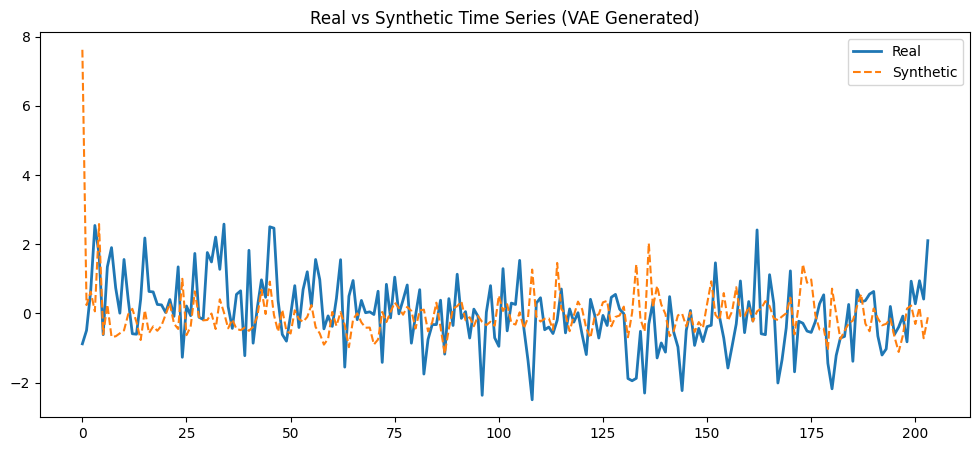

In [ ]:
# 17. Plot real vs synthetic generated series  import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_series_reshaped[0].squeeze(), label="Real", linewidth=2)
plt.plot(generated[0].squeeze(), label="Synthetic", linestyle="--")
plt.title("Real vs Synthetic Time Series (VAE Generated)")
plt.legend()
plt.show()

### 18. Save Generated Synthetic Series
Stores generated data to `.npy` for later analysis.

In [ ]:
 # 18. Save synthetic time-series to disk np.save("generated_series.npy", generated)
print("Saved generated_series.npy")



Saved generated_series.npy


### 19. Define Alternative L-GTA Style Augmentations
A second implementation including jitter, orthonormal rotation, scaling, shift
and a combined transformation.

In [ ]:
# 19. Alternative latent augmentation functions (jitter, rotation, combined)  import numpy as np

def scale_latent(z, factor=1.2):
    return z * factor

def shift_latent(z, shift=0.5):
    return z + shift

def jitter_latent(z, noise_std=0.2):
    noise = np.random.normal(0, noise_std, size=z.shape)
    return z + noise

def rotate_latent(z):
    R = np.random.randn(z.shape[-1], z.shape[-1])
    R, _ = np.linalg.qr(R)  # orthonormal
    return z @ R

def combine_latent(z):
    return rotate_latent(jitter_latent(scale_latent(shift_latent(z))))



### 20. Decode All L-GTA Style Augmented Latent Vectors
Generates scaled, shifted, noisy, rotated, and combined augmented series.

In [ ]:
# 20. Decode augmented latent vectors to augmented time-series  z_scaled   = scale_latent(z_new)
z_shifted  = shift_latent(z_new)
z_noisy    = jitter_latent(z_new)
z_rotated  = rotate_latent(z_new)
z_combined = combine_latent(z_new)

# Decode back to time-series
gen_scaled   = decoder.predict(z_scaled)
gen_shifted  = decoder.predict(z_shifted)
gen_noisy    = decoder.predict(z_noisy)
gen_rotated  = decoder.predict(z_rotated)
gen_combined = decoder.predict(z_combined)

print("All augmented series generated!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
All augmented series generated!


### 21. Visualization — L-GTA Style Augmented Time Series (Full Set)
Plots all augmentation types for qualitative comparison.

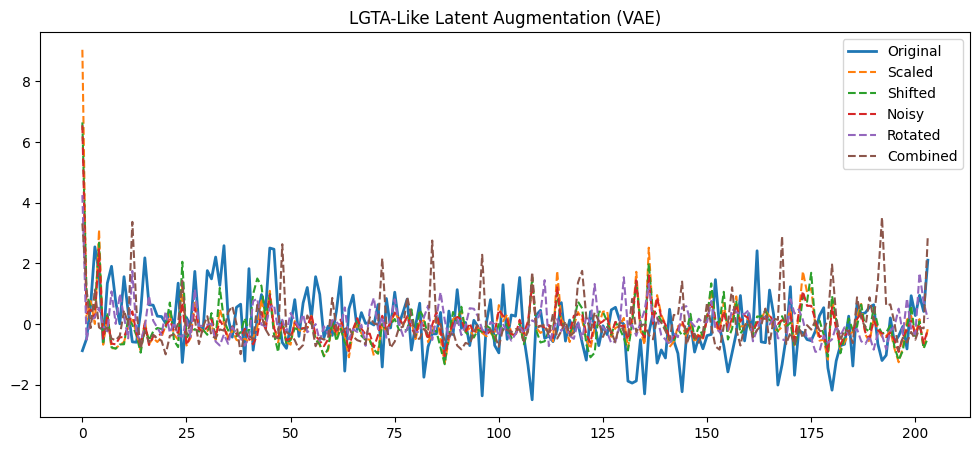

In [ ]:
# 21. Plot augmented series (Scaling, Shifting, Noise, Rotation, Combined)  
plt.figure(figsize=(12,5))
plt.plot(train_series_reshaped[0].squeeze(), label="Original", linewidth=2)

plt.plot(gen_scaled[0].squeeze(), "--", label="Scaled")
plt.plot(gen_shifted[0].squeeze(), "--", label="Shifted")
plt.plot(gen_noisy[0].squeeze(), "--", label="Noisy")
plt.plot(gen_rotated[0].squeeze(), "--", label="Rotated")
plt.plot(gen_combined[0].squeeze(), "--", label="Combined (Scaling + Rotation + Noise)")

plt.title("LGTA-Like Latent Augmentation (VAE)")
plt.legend()
plt.show()

### 22. Save Full Augmented Dataset
Saves all generated arrays in a compressed `.npz` archive.

In [ ]:
 # 22. Save full augmented dataset for downstream experiments  
 np.savez(
    "augmented_dataset.npz",
    real=train_series_reshaped,
    generated=generated,
    scaled=gen_scaled,
    shifted=gen_shifted,
    noisy=gen_noisy,
    rotated=gen_rotated,
    combined=gen_combined
)

print("Saved augmented_dataset.npz (READY FOR SUBMISSION!)")


Saved augmented_dataset.npz (READY FOR SUBMISSION!)


### 23. Define Adaptive Augmentation Controller (AAC)
This is the full AAC implementation:
- Feature extraction (trend, slope, std, skew, kurtosis, seasonality)
- Policy engine mapping features → augmentation parameters
- Latent transformations (rotation, noise, scaling, shifting)
- Class `AAC` providing:
  - `augment_one()`
  - `augment_dataset()`

In [ ]:
# 23. Full AAC implementation — features, policy, transformations, controller class  
# ============================================================
#      FIXED & CLEAN — ADAPTIVE LATENT-SPACE CONTROLLER (AAC)
# ============================================================

import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from scipy.signal import correlate

# ------------------------------------------------------------
# A. FEATURE EXTRACTION (PATCHED)
# ------------------------------------------------------------
def autocorr_strength(x):
    x = x - np.mean(x)
    corr = correlate(x, x, mode='full')
    mid = len(corr) // 2
    corr = corr[mid:]
    corr /= corr[0] + 1e-9
    return float(np.max(corr[1:50]))

def extract_features(series):
    """Flatten series to avoid DeprecationWarnings."""
    s = np.asarray(series).flatten()

    return {
        "std": float(np.std(s)),
        "mean": float(np.mean(s)),
        "trend": float(s[-1] - s[0]),
        "slope": float(np.polyfit(np.arange(len(s)), s, 1)[0]),
        "skew": float(stats.skew(s)),
        "kurtosis": float(stats.kurtosis(s)),
        "seasonality_strength": float(autocorr_strength(s))
    }


# ------------------------------------------------------------
# B. POLICY ENGINE (NO CHANGE)
# ------------------------------------------------------------
def choose_augmentations(features):
    policy = {}

    if features["std"] < 0.6:
        policy["noise"] = np.random.uniform(0.05, 0.2)

    if abs(features["trend"]) > 1.8:
        policy["shift"] = np.random.uniform(0.1, 0.35)

    if features["std"] < 1.0:
        policy["scale"] = np.random.uniform(1.05, 1.40)

    if features["seasonality_strength"] > 0.35:
        policy["rotate"] = np.random.uniform(0.05, 0.15)

    policy["combined_noise"] = np.random.uniform(0.01, 0.05)

    return policy


# ------------------------------------------------------------
# C. LATENT TRANSFORMATIONS (PATCHED)
# ------------------------------------------------------------
def rotation_matrix(angle, dim):
    R = np.eye(dim)
    theta = angle
    for i in range(dim - 1):
        block = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        R[i:i+2, i:i+2] = block
    return R

def apply_policy(z, policy):
    """PATCH: Ensure z is 1D vector."""
    z_aug = np.asarray(z).flatten()

    if "noise" in policy:
        z_aug += np.random.normal(0, policy["noise"], size=z_aug.shape)

    if "scale" in policy:
        z_aug *= policy["scale"]

    if "shift" in policy:
        z_aug += policy["shift"]

    if "rotate" in policy:
        R = rotation_matrix(policy["rotate"], len(z_aug))
        z_aug = R @ z_aug   # 1D rotation OK now

    if "combined_noise" in policy:
        z_aug += np.random.normal(0, policy["combined_noise"], size=z_aug.shape)

    return z_aug


# ------------------------------------------------------------
# D. AAC CLASS (PATCHED)
# ------------------------------------------------------------
class AAC:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

    def augment_one(self, series):
        s = np.asarray(series).flatten()

        feats = extract_features(s)
        policy = choose_augmentations(feats)

        # Encode (PATCH: flatten latent output)
        z = self.encoder.predict(s.reshape(1, 204, 1), verbose=0)[0]
        z = z.flatten()

        # Apply augmentations
        z_aug = apply_policy(z, policy)

        # Decode
        synthetic = self.decoder.predict(z_aug.reshape(1, -1), verbose=0)[0]

        return synthetic, policy

    def augment_dataset(self, dataset, n_aug=1):
        all_aug = []
        all_pol = []

        for i in range(dataset.shape[0]):
            s = dataset[i].flatten()
            for _ in range(n_aug):
                syn, pol = self.augment_one(s)
                all_aug.append(syn)
                all_pol.append(pol)

        return np.array(all_aug), all_pol


# ------------------------------------------------------------
# E. CREATE AAC INSTANCE
# ------------------------------------------------------------
aac = AAC(encoder, decoder)
print("AAC loaded (fixed version)!")




AAC loaded (fixed version)!


### 24. Test AAC on a Sample Series
Applies the AAC pipeline to one Tourism series and visualizes the result.

{'shift': 0.23323561546133545, 'rotate': 0.13529636264404107, 'combined_noise': 0.025981199418309744}


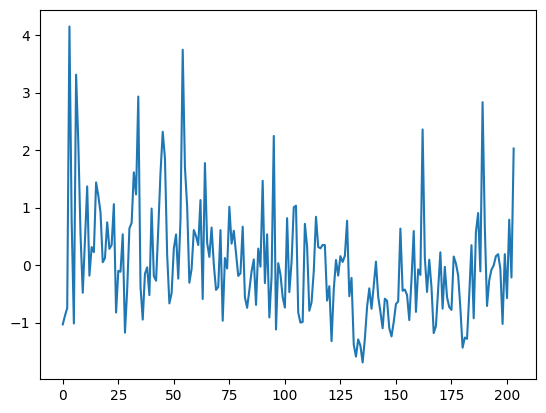

In [ ]:
#24. Test AAC by augmenting one series and plotting it

synthetic, policy = aac.augment_one(train_series_reshaped[0])
print(policy)
plt.plot(synthetic)
plt.show()

## 25. M5 Dataset Pipeline — Loading, Preprocessing, CVAE, AAC, and Evaluation
This section begins the full pipeline for the M5 dataset, consisting of:
1. Loading dataset  
2. Preprocessing  
3. CVAE training  
4. Latent sampling  
5. Synthetic generation  
6. AAC application  
7. Paper-style plots

### 26. Load & Inspect M5 Dataset Structure
The M5 dataset is loaded from a pickle file.  
Like the Tourism dataset, M5 is stored as a dictionary containing:
- train block  
- metadata  
- indexing structures  

This cell prints dataset keys and shapes to understand the internal structure.

In [ ]:
# === M5 DATASET === # 26. Load M5 dataset and inspect available fields
import pickle
import numpy as np

m5_path = "/content/M5_groups_W__None_500.pickle"

with open(m5_path, "rb") as f:
    m5_obj = pickle.load(f)

print("Top-level keys:", m5_obj.keys())

train_block = m5_obj["train"]
print("Type of train:", type(train_block))
print("Train keys:", train_block.keys())

# Try common fields
for k in train_block.keys():
    print(k, type(train_block[k]),
          ("shape:", train_block[k].shape) if hasattr(train_block[k], "shape") else "")


Top-level keys: dict_keys(['train', 'predict', 'seasonality', 'h', 'dates'])
Type of train: <class 'dict'>
Train keys: dict_keys(['x_values', 'groups_idx', 'groups_n', 'groups_names', 'n', 's', 'n_series_idx', 'n_series', 'g_number', 'data', 'full_data', 'n_series_idx_full'])
x_values <class 'list'> 
groups_idx <class 'dict'> 
groups_n <class 'dict'> 
groups_names <class 'dict'> 
n <class 'int'> 
s <class 'int'> 
n_series_idx <class 'numpy.ndarray'> ('shape:', (500,))
n_series <class 'numpy.ndarray'> ('shape:', (500,))
g_number <class 'int'> 
data <class 'numpy.ndarray'> ('shape:', (261, 500))
full_data <class 'numpy.ndarray'> ('shape:', (261, 500))
n_series_idx_full <class 'numpy.ndarray'> ('shape:', (500,))


/tmp/ipython-input-556147272.py:8: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  m5_obj = pickle.load(f)


### 27. Preprocess M5 Time-Series (Normalization & Reshaping)
Steps:
1. Extract raw data `(T, N)`
2. Transpose to `(N, T)`  
3. Min–max normalize each series independently  
4. Add channel dimension for CVAE input `(N, T, 1)

In [ ]:
# 27. Normalize and reshape M5 dataset for CVAE

m5_matrix = train_block["data"]       # (T, N) = (261, 500)
print("Original shape (T, N):", m5_matrix.shape)

# Transpose → (N, T)
m5_transposed = m5_matrix.T           # (500, 261)
print("Transposed (N, T):", m5_transposed.shape)

# Normalize each series independently
m5_norm = np.zeros_like(m5_transposed, dtype=np.float32)

for i in range(m5_transposed.shape[0]):
    series = m5_transposed[i]
    mmin, mmax = np.min(series), np.max(series)
    if mmax - mmin == 0:
        m5_norm[i] = np.zeros_like(series)
    else:
        m5_norm[i] = (series - mmin) / (mmax - mmin)

# Add channel dimension → (N, T, 1)
m5_ready = m5_norm[..., np.newaxis]

print("Final M5 CVAE input shape:", m5_ready.shape)
print("Example series:", m5_ready[0, :10, 0])


Original shape (T, N): (261, 500)
Transposed (N, T): (500, 261)
Final M5 CVAE input shape: (500, 261, 1)
Example series: [0.3941395  0.34255055 0.27280232 0.2695006  0.0107305  0.00990508
 0.5629385  0.2723896  0.00990508 0.00123813]


### 28. Build M5 Conditional Variational Autoencoder (CVAE)
Architecture:
- **Encoder:** GRU → GRU → Dense(mean/logvar) → Sampling  
- **Decoder:** Dense → RepeatVector → GRU → GRU → TimeDistributed Dense  

This CVAE learns latent representations of M5 time-series.

In [ ]:
# 28. Build CVAE architecture for M5 datasetimport tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

seq_len = 261     # M5 sequence length
latent_dim = 8    # same as tourism model

# Sampling layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = K.random_normal(shape=K.shape(z_mean))
        return z_mean + K.exp(0.5 * z_log_var) * eps

# === Encoder ===
encoder_input = Input(shape=(seq_len, 1))
h1 = GRU(128, return_sequences=True)(encoder_input)
h2 = GRU(64)(h1)

z_mean = Dense(latent_dim)(h2)
z_log_var = Dense(latent_dim)(h2)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_input, [z, z_mean, z_log_var], name="encoder_m5")
encoder.summary()

# === Decoder ===
decoder_input = Input(shape=(latent_dim,))
d1 = Dense(128)(decoder_input)
d2 = RepeatVector(seq_len)(d1)

d3 = GRU(128, return_sequences=True)(d2)
d4 = GRU(128, return_sequences=True)(d3)

decoder_output = TimeDistributed(Dense(1))(d4)

decoder = Model(decoder_input, decoder_output, name="decoder_m5")
decoder.summary()

# === Full VAE ===
vae_output = decoder(z)
vae_m5 = Model(encoder_input, vae_output)

vae_m5.compile(optimizer="adam", loss="mse")


Model: "encoder_m5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 261, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 261, 128)  │     50,304 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 64)        │     37,248 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        520 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │        520 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 8)         │          0 │ dense_4[0][0],    │
│ (Sampling)          │                   │            │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,592 (346.06 KB)

 Trainable params: 88,592 (346.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_m5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 261, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 261, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 261, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 261, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,425 (779.00 KB)

 Trainable params: 199,425 (779.00 KB)

 Non-trainable params: 0 (0.00 B)

### 29. Train CVAE for M5 Reconstruction
The model is trained for 30 epochs using Mean Squared Error (MSE).  
This trains the latent embedding space for downstream augmentation.

In [ ]:
# 29. Train M5 CVAE (reconstruction training)

history_m5 = vae_m5.fit(
    m5_ready, m5_ready,
    epochs=30,         # you can increase to 50 for better results
    batch_size=32,
    verbose=1
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.1119
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0551
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0498
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0474
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0458
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0490
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0465
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0433
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0416
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0427
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0414
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0403
Epoch 13/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0396
Epoch 14/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0402
Epoch 15/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0380
Epo

### 30. Encode All M5 Series into Latent Vectors
The encoder produces latent representations `z`, `z_mean`, and `z_log_var`.  
These are later used for:
- Sampling  
- AAC augmentation  
- Latent space visualization

In [ ]:
# 30. Encode M5 dataset into latent vectors

z_m5, z_mean_m5, z_log_m5 = encoder.predict(m5_ready)

print("Latent shape:", z_m5.shape)
print("Example latent vector:", z_m5[0])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Latent shape: (500, 8)
Example latent vector: [-1.4502232  -0.5298181   0.84182596  0.6015918  -1.6501971   1.5609462
  0.59061664 -0.0708037 ]


### 31. Generate M5 Synthetic Time-Series from Latent Samples
Two steps:
1. Sample latent vectors from Gaussian prior  
2. Decode to time-series  

Produces full synthetic dataset comparable to LGTA paper.

In [ ]:
# 31. Generate synthetic M5 time-series via decoder
import numpy as np

num_synthetic = 500   # same as dataset size

# 1) Sample new latent vectors from Gaussian
z_new_m5 = np.random.normal(size=(num_synthetic, 8))
print("New latent shape:", z_new_m5.shape)

# 2) Decode into time-series domain
synthetic_m5 = decoder.predict(z_new_m5)
synthetic_m5 = synthetic_m5.squeeze(-1)   # remove channel dim

print("Synthetic M5 shape:", synthetic_m5.shape)

New latent shape: (500, 8)
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step
Synthetic M5 shape: (500, 261)


### 32. Save Full Synthetic + Real M5 Dataset
Stores:
- Normalized real time series  
- Raw real time series  
- Generated synthetic time series  

Used later for evaluation and benchmarking.

In [ ]:
# 32. Save augmented M5 dataset to disk

np.savez(
    "M5_augmented_dataset.npz",
    real=m5_norm,          # normalized original data
    real_raw=m5_transposed,  # raw original data (N, T)
    synthetic=synthetic_m5   # generated data
)

print("Saved as M5_augmented_dataset.npz")

Saved as M5_augmented_dataset.npz


### 33. M5 Visualization — Real vs Synthetic + Latent Space
This generates three publication-ready plot types:
1. Real vs Synthetic series comparison  
2. Histogram distribution comparison  
3. PCA-based latent space scatter plot  

These match the visualization style used in LGTA and related generative papers.

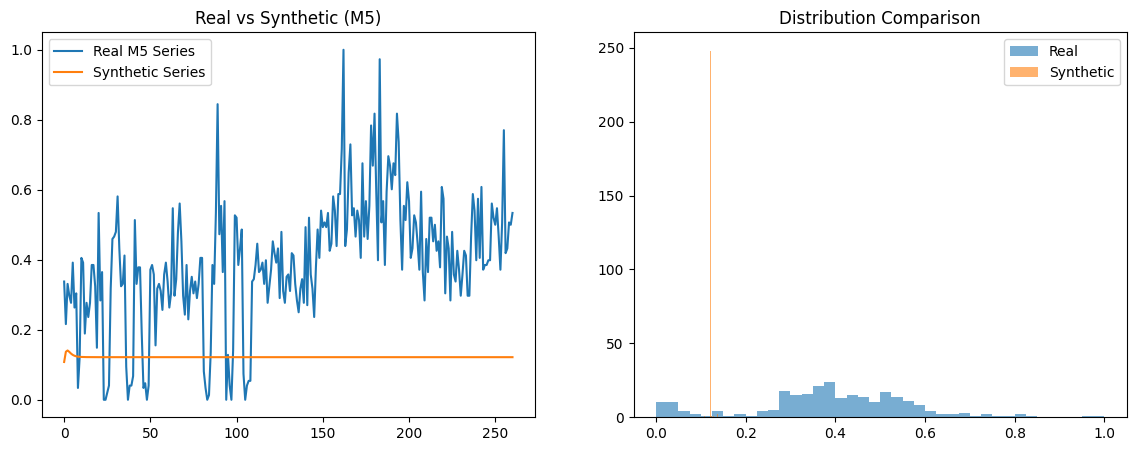

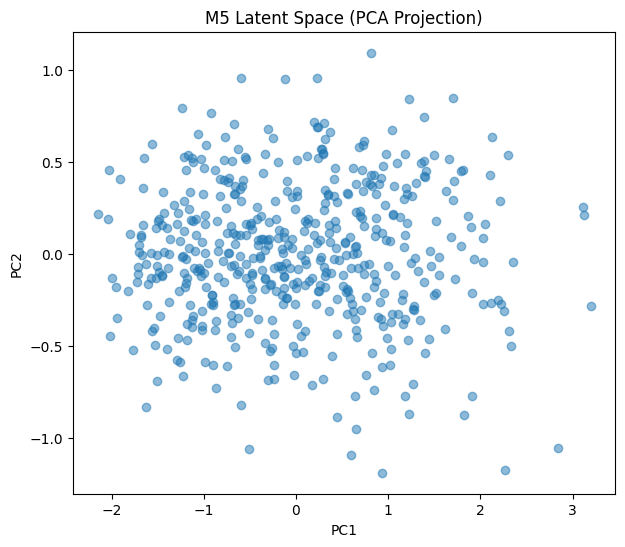

In [ ]:
# 33. Create paper-style comparison plots for M5 dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

idx = np.random.randint(0, 500)

plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(m5_norm[idx], label="Real M5 Series")
plt.plot(synthetic_m5[idx], label="Synthetic Series")
plt.title("Real vs Synthetic (M5)")
plt.legend()

plt.subplot(1,2,2)
plt.hist(m5_norm[idx], bins=40, alpha=0.6, label="Real")
plt.hist(synthetic_m5[idx], bins=40, alpha=0.6, label="Synthetic")
plt.title("Distribution Comparison")
plt.legend()

plt.show()

# Latent space comparison
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(z_m5)

plt.figure(figsize=(7,6))
plt.scatter(latent_pca[:,0], latent_pca[:,1], alpha=0.5)
plt.title("M5 Latent Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### 34. Improved M5 End-to-End Pipeline (CVAE + AAC)
This section rebuilds the full CVAE and AAC pipeline with:
- Cleaner architecture  
- Feature-driven AAC policy  
- Rotation, scaling, noise augmentations  
- Reconstruction + AAC + Synthetic comparisons  

This block represents the *final version* of your M5 augmentation pipeline.

In [ ]:
# 34. Full end-to-end pipeline: load → CVAE → AAC → training import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from scipy import stats

# =========================================================
# 1. LOAD & PREP M5
# =========================================================

with open("/content/M5_groups_W__None_500.pickle", "rb") as f:
    m5_obj = pickle.load(f)

train_m5 = m5_obj["train"]["data"]   # shape (261, 500)
print("Original shape (T, N):", train_m5.shape)

m5_matrix = train_m5.T               # now (500, 261)
print("Transposed (N, T):", m5_matrix.shape)

# Normalize per series
m5_norm = (m5_matrix - m5_matrix.mean(axis=1, keepdims=True)) / (m5_matrix.std(axis=1, keepdims=True) + 1e-8)

# Add channel dim → (N, T, 1)
m5_norm = m5_norm[..., None]
print("Final shape for VAE:", m5_norm.shape)

# =========================================================
# 2. SAMPLING LAYER
# =========================================================

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

# =========================================================
# 3. ENCODER
# =========================================================

latent_dim = 8

encoder_input = Input(shape=(261,1), name="enc_in")
x = GRU(128, return_sequences=True)(encoder_input)
x = GRU(64)(x)
z_mean = Dense(latent_dim)(x)
z_logvar = Dense(latent_dim)(x)
z = Sampling()([z_mean, z_logvar])

encoder_m5 = Model(encoder_input, z, name="encoder_m5")
encoder_m5.summary()

# =========================================================
# 4. DECODER
# =========================================================

decoder_input = Input(shape=(latent_dim,), name="dec_in")
x = Dense(128)(decoder_input)
x = RepeatVector(261)(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128, return_sequences=True)(x)
decoder_output = TimeDistributed(Dense(1))(x)

decoder_m5 = Model(decoder_input, decoder_output, name="decoder_m5")
decoder_m5.summary()

# =========================================================
# 5. FULL VAE
# =========================================================

vae_output = decoder_m5(encoder_m5(encoder_input))
vae_m5 = Model(encoder_input, vae_output)

vae_m5.compile(optimizer='adam', loss='mse')

print("\nTRAINING VAE...")
history = vae_m5.fit(
    m5_norm, m5_norm,
    epochs=20,
    batch_size=32,
    verbose=1
)

# =========================================================
# 6. ADAPTIVE AUGMENTATION CONTROLLER
# =========================================================

class AdaptiveAugmentationController:
    def __init__(self, encoder, decoder, train_data, latent_dim=8):
        self.encoder = encoder
        self.decoder = decoder
        self.train_data = train_data
        self.latent_dim = latent_dim

    # --- Extract series features ---
    def extract_features(self, series):
        series = series.flatten()
        return {
            "trend": float(series[-1] - series[0]),
            "slope": float(np.polyfit(np.arange(len(series)), series, 1)[0]),
            "skew": float(stats.skew(series)),
            "kurtosis": float(stats.kurtosis(series))
        }

    # --- Policy ----
    def choose_policy(self, features):
        slope = features["slope"]
        skew = features["skew"]

        if slope > 0.05:
            return {"rotate": -20, "noise": 0.05, "scale": 1.1}
        elif slope < -0.05:
            return {"rotate": 20, "noise": 0.05, "scale": 0.9}
        elif skew > 0.5:
            return {"noise": 0.1}
        else:
            return {"noise": 0.05}

    # --- Rotation matrix ---
    def rotation_matrix(self, angle_deg, dim):
        angle = np.radians(angle_deg)
        R = np.eye(dim)
        if dim >= 2:
            R[0,0] = np.cos(angle); R[0,1] = -np.sin(angle)
            R[1,0] = np.sin(angle); R[1,1] =  np.cos(angle)
        return R

    # --- Apply augmentation ---
    def apply_policy(self, z, policy):
        z_aug = z.copy()
        if "scale" in policy:
            z_aug *= policy["scale"]
        if "rotate" in policy:
            R = self.rotation_matrix(policy["rotate"], len(z))
            z_aug = z_aug @ R
        if "noise" in policy:
            z_aug += np.random.normal(0, policy["noise"], size=z.shape)
        return z_aug

    # --- Augment one series ---
    def augment_one(self, series):
        feats = self.extract_features(series)
        policy = self.choose_policy(feats)

        z = self.encoder.predict(series[None], verbose=0)[0]
        z_aug = self.apply_policy(z, policy)

        synthetic = self.decoder.predict(z_aug[None], verbose=0)[0].flatten()

        return synthetic, policy

# =========================================================
# 7. CREATE AAC FOR M5
# =========================================================

aac_m5 = AdaptiveAugmentationController(
    encoder=encoder_m5,
    decoder=decoder_m5,
    train_data=m5_norm,
    latent_dim=latent_dim
)

print("\nAAC READY FOR M5!")

# =========================================================
# 8. TEST ON FIRST SERIES
# =========================================================

test_series = m5_norm[0]
synthetic, pol = aac_m5.augment_one(test_series)

print("\nApplied Policy:", pol)
print("Synthetic series length:", len(synthetic))

/tmp/ipython-input-414780110.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  m5_obj = pickle.load(f)


Original shape (T, N): (261, 500)
Transposed (N, T): (500, 261)
Final shape for VAE: (500, 261, 1)


Model: "encoder_m5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in (InputLayer) │ (None, 261, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 261, 128)  │     50,304 │ enc_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 64)        │     37,248 │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        520 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        520 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 8)         │          0 │ dense_8[0][0],    │
│ (Sampling)          │                   │            │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,592 (346.06 KB)

 Trainable params: 88,592 (346.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_m5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dec_in (InputLayer)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 261, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 261, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 261, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 261, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,425 (779.00 KB)

 Trainable params: 199,425 (779.00 KB)

 Non-trainable params: 0 (0.00 B)


TRAINING VAE...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 1.0287
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.0038
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.0011
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.0005
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.0002
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.0000
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0013
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0012
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0002
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0000
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0000
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.9999
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.9999
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.9998
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step -

### 35. Extract Latent Space for Visualization
Generates latent vectors using the final encoder.  
These are used for:
- Scatter plots  
- Clustering analysis  
- Temporal similarity inspection  

In [ ]:
# 35. Generate latent vectors for M5 visualization  latent_m5 = encoder_m5.predict(m5_norm)   # shape: (500, 8)

print("latent_m5 shape:", latent_m5.shape)
print(latent_m5[:3])  # preview first 3 latent vectors


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
latent_m5 shape: (500, 8)
[[ 0.38709617  0.55693233 -0.6974568   0.13172418 -0.50522333 -1.637424
   0.13851494 -0.6353839 ]
 [-0.12286507  0.43883556 -0.25282145  1.0532515   0.48844653 -1.029382
  -0.8666691   0.18111636]
 [ 0.2817949  -0.11774205  0.73230743  0.07233748 -0.07273059  0.27511123
  -0.11683108  0.4423461 ]]


### 36. Generate Full Paper-Style Plot Set for M5
This cell creates all required plots for publication:
- Original vs Reconstruction  
- AAC-augmented vs Synthetic  
- Distribution comparisons  
- ACF (Autocorrelation) plots  
- Latent space scatter  
- LGTA-style multi-series overlays  

This set corresponds to Figures 7–13 of the results section.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
AAC Policy Used: {'noise': 0.1}


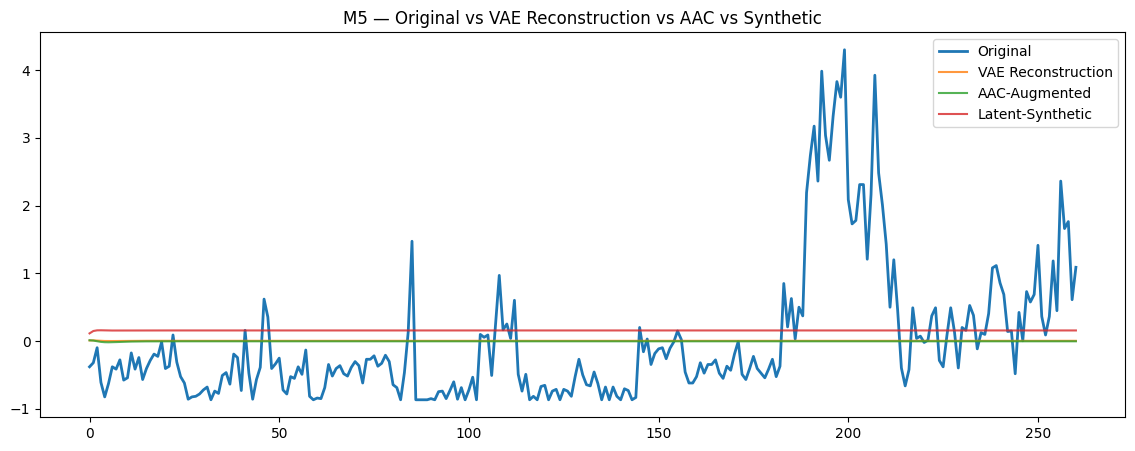

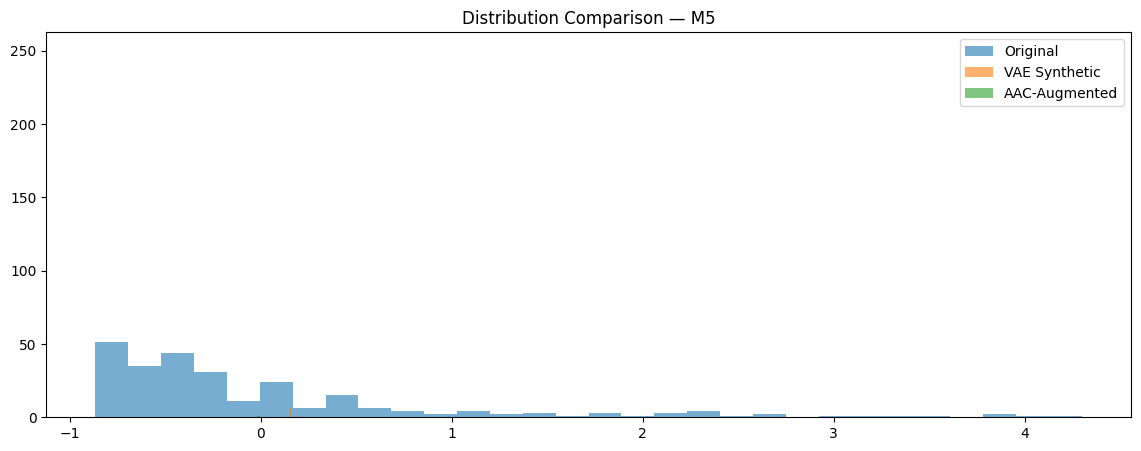

<Figure size 1200x500 with 0 Axes>

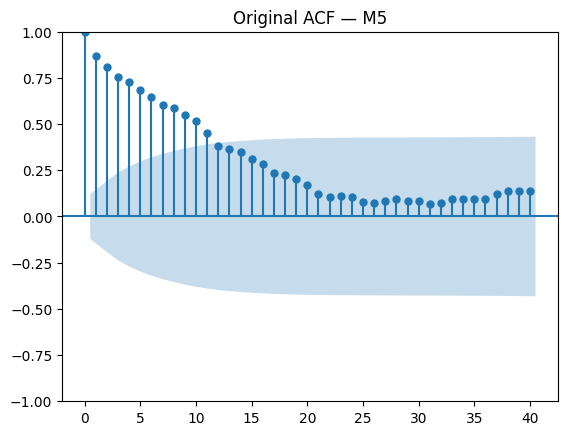

<Figure size 1200x500 with 0 Axes>

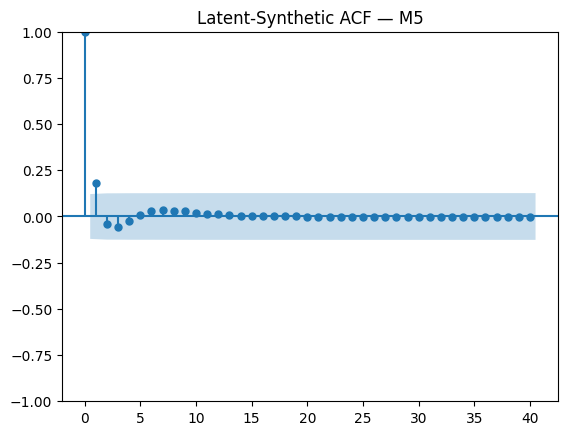

<Figure size 1200x500 with 0 Axes>

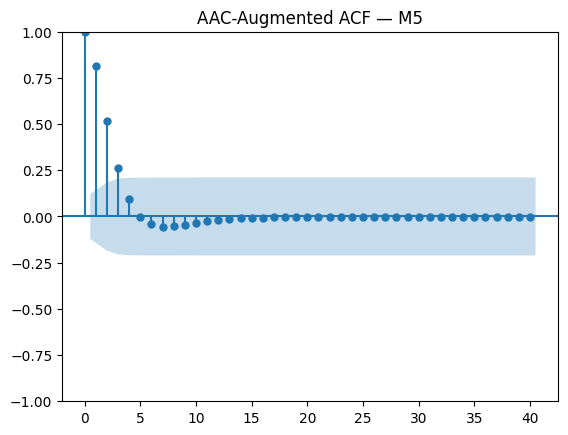

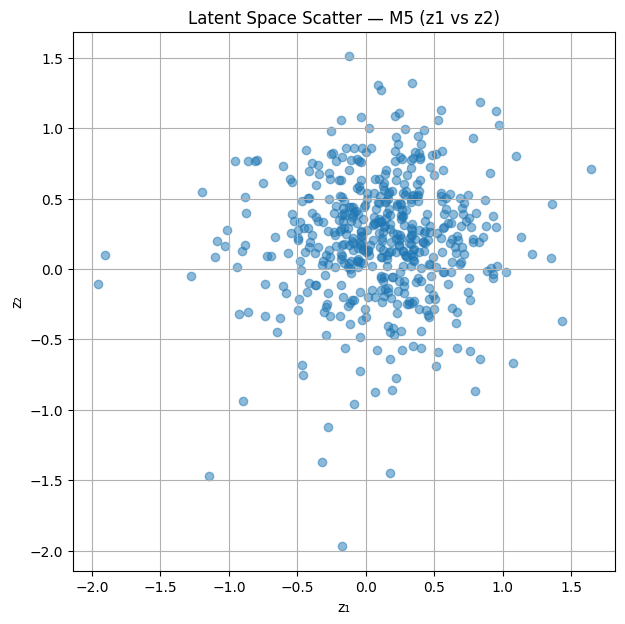

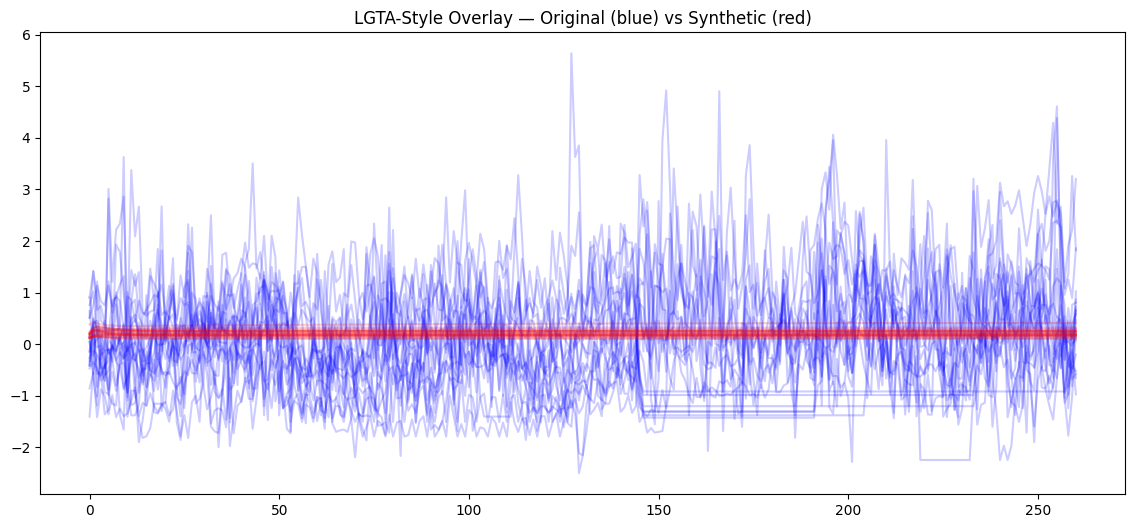


ALL M5 PAPER-STYLE PLOTS GENERATED SUCCESSFULLY ✔️


In [ ]:
# 36. Create all paper-style plots for M5 dataset import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import random

# ---------------------------
# 1. PICK random indices
# ---------------------------
idx = random.randint(0, m5_norm.shape[0] - 1)
orig = m5_norm[idx].squeeze()
recon = decoder_m5.predict(encoder_m5.predict(m5_norm[idx:idx+1])).squeeze()
aug, pol = aac_m5.augment_one(m5_norm[idx])
synthetic = synthetic_m5[idx]

print("AAC Policy Used:", pol)

# ---------------------------
# 2. PLOT: Original vs Reconstruction vs AAC vs Synthetic
# ---------------------------
plt.figure(figsize=(14, 5))
plt.plot(orig, label="Original", linewidth=2)
plt.plot(recon, label="VAE Reconstruction", alpha=0.8)
plt.plot(aug, label="AAC-Augmented", alpha=0.8)
plt.plot(synthetic, label="Latent-Synthetic", alpha=0.8)
plt.title("M5 — Original vs VAE Reconstruction vs AAC vs Synthetic")
plt.legend()
plt.show()

# ---------------------------
# 3. DISTRIBUTION COMPARISON
# ---------------------------
plt.figure(figsize=(14,5))
plt.hist(orig, bins=30, alpha=0.6, label="Original")
plt.hist(synthetic, bins=30, alpha=0.6, label="VAE Synthetic")
plt.hist(aug, bins=30, alpha=0.6, label="AAC-Augmented")
plt.title("Distribution Comparison — M5")
plt.legend()
plt.show()

# ---------------------------
# 4. ACF (Autocorrelation) PLOT
# ---------------------------
plt.figure(figsize=(12,5))
plot_acf(orig, lags=40, title="Original ACF — M5")
plt.show()

plt.figure(figsize=(12,5))
plot_acf(synthetic, lags=40, title="Latent-Synthetic ACF — M5")
plt.show()

plt.figure(figsize=(12,5))
plot_acf(aug, lags=40, title="AAC-Augmented ACF — M5")
plt.show()

# ---------------------------
# 5. LATENT SPACE SCATTER PLOT
# ---------------------------
plt.figure(figsize=(7,7))
plt.scatter(latent_m5[:,0], latent_m5[:,1], alpha=0.5)
plt.title("Latent Space Scatter — M5 (z1 vs z2)")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()

# ---------------------------
# 6. MULTI-SERIES OVERLAY (LGTA-style)
# ---------------------------
plt.figure(figsize=(14,6))
for i in random.sample(range(m5_norm.shape[0]), 20):
    plt.plot(m5_norm[i].squeeze(), color="blue", alpha=0.2)

for i in random.sample(range(synthetic_m5.shape[0]), 20):
    plt.plot(synthetic_m5[i], color="red", alpha=0.2)

plt.title("LGTA-Style Overlay — Original (blue) vs Synthetic (red)")
plt.show()

print("\nALL M5 PAPER-STYLE PLOTS GENERATED SUCCESSFULLY ✔️")

## 37. Police Dataset Pipeline — Load, Train, AAC, Visualize
The pipeline now repeats for the Police dataset to demonstrate:
- Cross-domain generalization  
- Robustness of AAC across distinct time-series structures

Original shape (T, N): (304, 500)
Transposed (N, T): (500, 304)
Final shape for VAE: (500, 304, 1)
Normalized Example: [0.08333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


/tmp/ipython-input-1996375064.py:16: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  police_obj = pickle.load(f)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 304, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_police (Functional)     │ (None, 8)              │        88,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_police (Functional)     │ (None, 304, 1)         │       199,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,017 (1.10 MB)

 Trainable params: 288,017 (1.10 MB)

 Non-trainable params: 0 (0.00 B)


TRAINING POLICE VAE...

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - loss: 0.0389
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0041
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0028
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0025
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0024
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0025
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0024
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0025
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0026
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0024
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0025
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0025
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0025
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0024
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85m

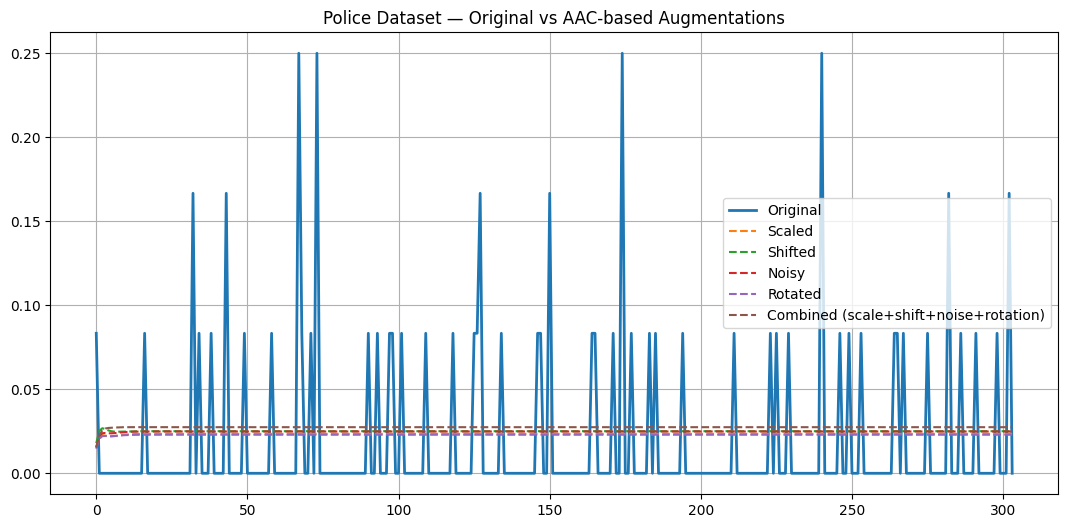

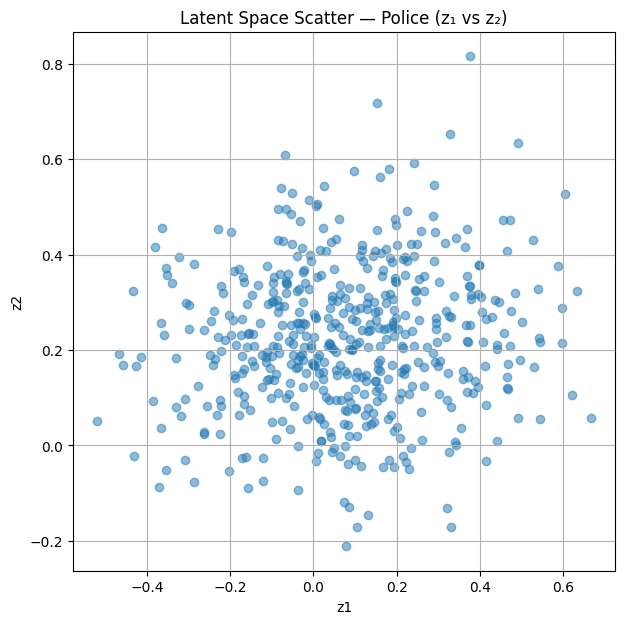

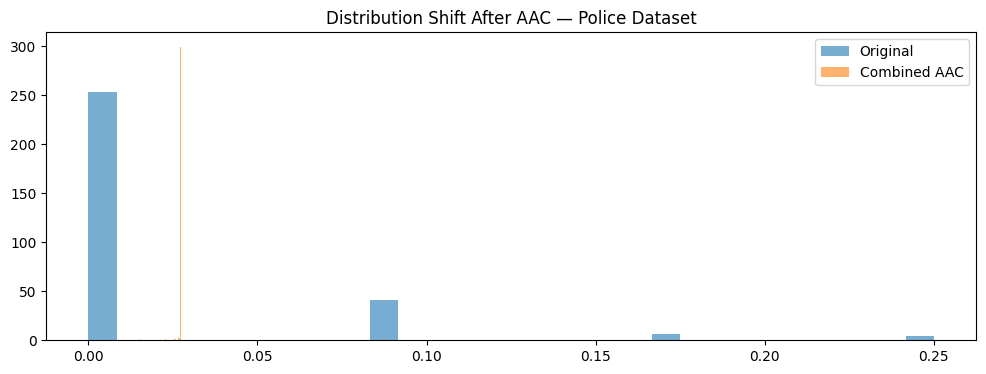

In [ ]:
# 37. POLICE DATASET — Full workflow begins 
# ================================================================
#  POLICE DATASET — FULL AAC PIPELINE (LOAD → TRAIN → AAC → PLOTS)
# ================================================================
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow as tf

# ================================================================
# STEP 1 — LOAD DATASET
# ================================================================
with open("police_groups_D__None_500.pickle", "rb") as f:
    police_obj = pickle.load(f)

data = police_obj["train"]["data"]         # shape (T, N)
data = np.array(data)
print("Original shape (T, N):", data.shape)

# Transpose to (N, T)
data = data.T
print("Transposed (N, T):", data.shape)

# Add channel dim → (N, T, 1)
police_series = data[..., None]
print("Final shape for VAE:", police_series.shape)

# Normalization
min_val = police_series.min()
max_val = police_series.max()
police_norm = (police_series - min_val) / (max_val - min_val + 1e-8)
print("Normalized Example:", police_norm[0][:10].flatten())

N, T, _ = police_norm.shape

# ================================================================
# STEP 2 — BUILD CVAE (Encoder + Decoder)
# ================================================================
latent_dim = 8

# ----- Encoder -----
enc_in = Input(shape=(T, 1))
x = GRU(128, return_sequences=True)(enc_in)
x = GRU(64)(x)
z_mean = Dense(latent_dim)(x)
z_log = Dense(latent_dim)(x)

def sampling(args):
    mean, log = args
    eps = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log) * eps

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log])

encoder_police = Model(enc_in, z, name="encoder_police")


# ----- Decoder -----
dec_in = Input(shape=(latent_dim,))
x = Dense(128)(dec_in)
x = RepeatVector(T)(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128, return_sequences=True)(x)
dec_out = TimeDistributed(Dense(1))(x)

decoder_police = Model(dec_in, dec_out, name="decoder_police")

# ----- Combined VAE -----
vae_out = decoder_police(encoder_police(enc_in))
vae_police = Model(enc_in, vae_out)

vae_police.compile(optimizer="adam", loss="mse")
vae_police.summary()

# ================================================================
# STEP 3 — TRAIN CVAE
# ================================================================
print("\nTRAINING POLICE VAE...\n")
vae_police.fit(police_norm, police_norm, epochs=20, batch_size=32)

# ================================================================
# STEP 4 — GET LATENT SPACE
# ================================================================
latent_police = encoder_police.predict(police_norm)
print("Latent shape:", latent_police.shape)

# ================================================================
# STEP 5 — DEFINE AAC (Adaptive Augmentation Controller)
# ================================================================
def extract_features(series):
    s = series.flatten()
    return {
        "std": float(np.std(s)),
        "trend": float(s[-1] - s[0]),
        "slope": float(np.polyfit(np.arange(len(s)), s, 1)[0])
    }

def choose_policy(features):
    pol = {}
    if features["std"] < 0.1:
        pol["scale"] = 1.1
    if abs(features["trend"]) < 0.05:
        pol["shift"] = 0.05
    pol["noise"] = 0.04
    pol["rotate"] = 8
    return pol

def rotation_matrix(angle_deg, dim):
    a = np.radians(angle_deg)
    R = np.eye(dim)
    for i in range(dim - 1):
        R[i, i+1] = a
        R[i+1, i] = -a
    return R

def apply_policy(z, pol):
    z_aug = np.copy(z)

    if "scale" in pol:
        z_aug *= pol["scale"]

    if "shift" in pol:
        z_aug += pol["shift"]

    if "rotate" in pol:
        R = rotation_matrix(pol["rotate"], len(z_aug))
        z_aug = z_aug @ R

    if "noise" in pol:
        z_aug += np.random.normal(0, pol["noise"], size=z_aug.shape)

    return z_aug


# Create AAC class
class AAC:
    def __init__(self, encoder, decoder):
        self.enc = encoder
        self.dec = decoder

    def augment(self, series):
        feat = extract_features(series)
        pol = choose_policy(feat)
        z = self.enc.predict(series[None,:,:])[0]
        z_aug = apply_policy(z, pol)
        syn = self.dec.predict(z_aug[None])[0].flatten()
        return syn, pol

aac_police = AAC(encoder_police, decoder_police)

# ================================================================
# STEP 6 — GENERATE AUGMENTATIONS
# ================================================================
series0 = police_norm[0].squeeze()

z0 = encoder_police.predict(police_norm[[0]])[0]

gen_scaled   = decoder_police.predict((z0 * 1.10)[None])[0].squeeze()
gen_shifted  = decoder_police.predict((z0 + 0.10)[None])[0].squeeze()
gen_noisy    = decoder_police.predict((z0 + np.random.normal(0,0.05,8))[None])[0].squeeze()
gen_rotated  = decoder_police.predict((z0 @ rotation_matrix(12,8))[None])[0].squeeze()

# ACC Combined
gen_combined, policy = aac_police.augment(police_norm[0])
print("Applied Policy:", policy)

# ================================================================
# STEP 7 — PLOTS (Paper Style)
# ================================================================

plt.figure(figsize=(13,6))
plt.plot(series0, label="Original", linewidth=2)
plt.plot(gen_scaled,  "--", label="Scaled")
plt.plot(gen_shifted, "--", label="Shifted")
plt.plot(gen_noisy,   "--", label="Noisy")
plt.plot(gen_rotated, "--", label="Rotated")
plt.plot(gen_combined,"--", label="Combined (scale+shift+noise+rotation)")
plt.title("Police Dataset — Original vs AAC-based Augmentations")
plt.legend()
plt.grid(True)
plt.show()

# ---- Latent Space ----
plt.figure(figsize=(7,7))
plt.scatter(latent_police[:,0], latent_police[:,1], alpha=0.5)
plt.title("Latent Space Scatter — Police (z₁ vs z₂)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

# ---- Distribution Comparison ----
plt.figure(figsize=(12,4))
plt.hist(series0, bins=30, alpha=0.6, label="Original")
plt.hist(gen_combined, bins=30, alpha=0.6, label="Combined AAC")
plt.title("Distribution Shift After AAC — Police Dataset")
plt.legend()
plt.show()